# Homework 8

[[ 7]
 [ 0]
 [53]]


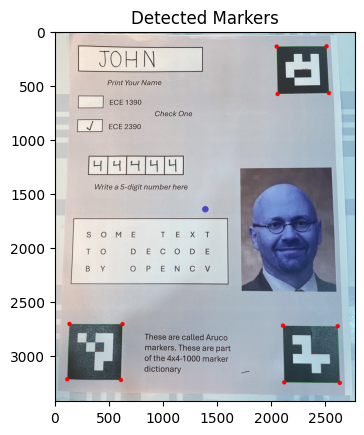

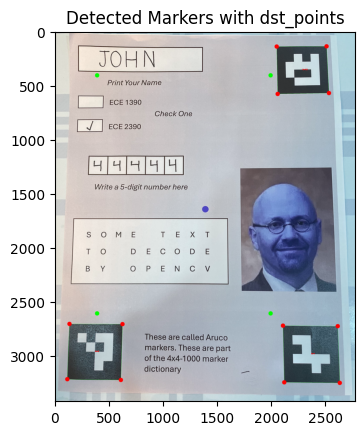

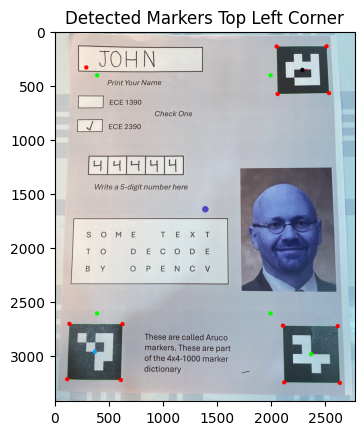

[[2362.25, 2986.5], [368.75, 2963.75], [2281.75, 359.5], [288.25, 336.75]]
[[1988.  409.]
 [1988. 2609.]
 [ 388. 2609.]
 [ 388.  409.]]


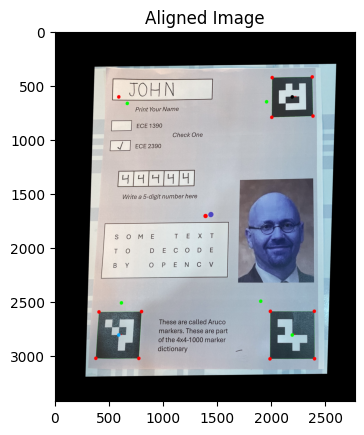

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected Text: JOHN


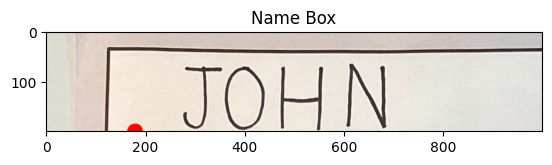

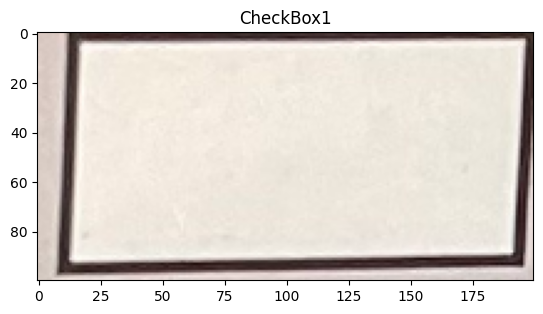

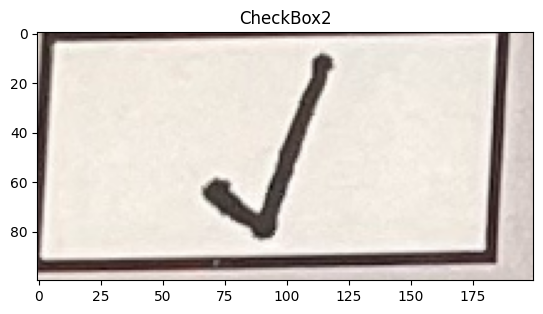

Marked Checkbox: ECE-2390


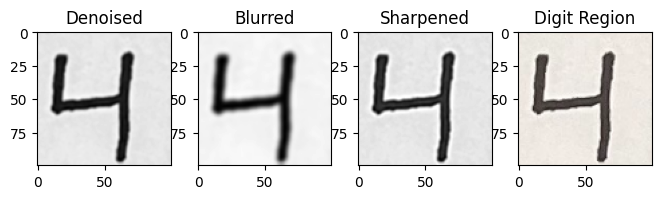

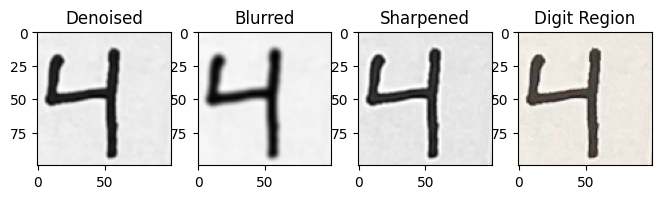

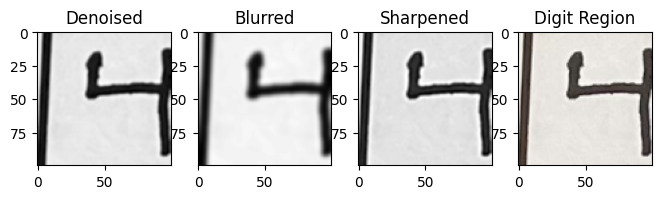

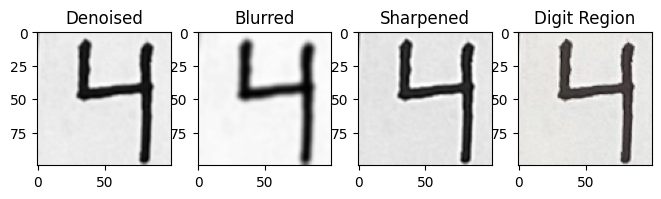

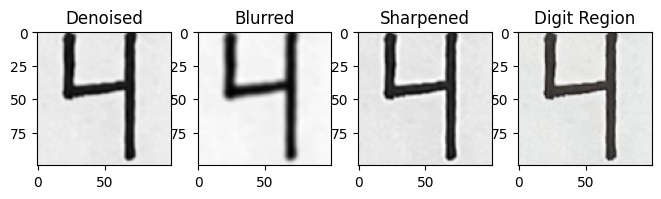

Decoded 5-Digit Number: [-1, -1, '4', '4', '4']


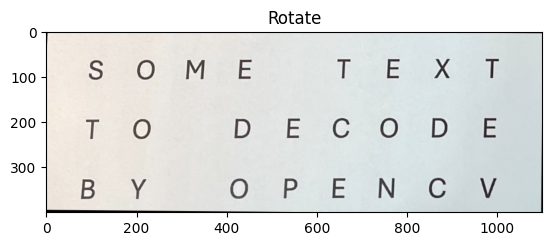

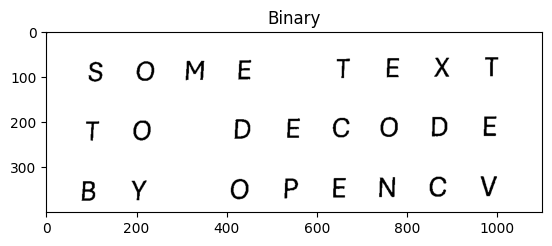

Confidence: 27
Text: SOME

Confidence: 62
Text: T

Confidence: 47
Text: XG

Confidence: 44
Text: ie

Confidence: 80
Text: @

Confidence: 82
Text: D

Confidence: 88
Text: E

Confidence: 11
Text: C/O

Confidence: 42
Text: Bray

Confidence: 84
Text: O

Confidence: 84
Text: P

Confidence: 46
Text: E

Confidence: 86
Text: N



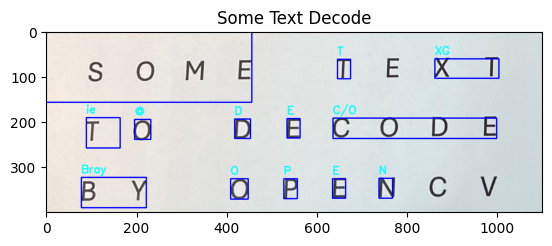

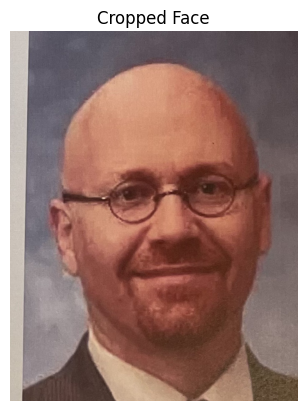

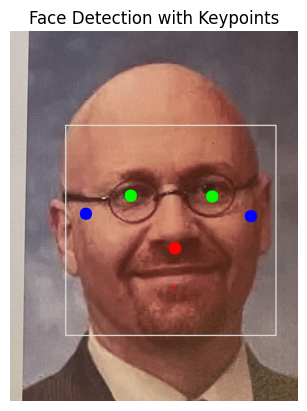

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import pytesseract
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import argparse
from typing import Tuple, Union
import math
import os

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Step 1: Load the image
image_path = "Color.jpg"  # Replace with the path to your file
real_image = cv2.imread(image_path)

image = real_image.copy()

# Red dot center (in pixels, approximate)
red_dot_x, red_dot_y = image.shape[1] // 2, image.shape[0] // 2

CM_TO_PIXELS = 100
# Step 2: Detect and align using Aruco markers
def align_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the Aruco dictionary and detect markers
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejected = detector.detectMarkers(gray)
    
    print(ids)
    
    cv2.aruco.drawDetectedMarkers(image, corners, ids)
    # Draw circles on all detected corners
    if corners:
        for marker_corners in corners:
            for corner in marker_corners[0]:  # marker_corners[0] gives the 4 corners of the marker
                x, y = int(corner[0]), int(corner[1])  # Convert to integers
                image = cv2.circle(image, (x, y), 20, (255, 0, 0), -1)  # Draw a filled circle
    
    plt.imshow(image)
    plt.title("Detected Markers")
    plt.show()
    
    # Define the three known points
    lower_left = np.array([6 * CM_TO_PIXELS + image.shape[1] // 2, -13 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    upper_right = np.array([-10 * CM_TO_PIXELS + image.shape[1] // 2, 9 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    lower_right = np.array([6 * CM_TO_PIXELS + image.shape[1] // 2, 9 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    # Calculate the upper-left point (UL)
    upper_left = upper_right - (lower_right - lower_left)

    # Add the upper-left point to dst_points array
    dst_points = np.array([
        lower_left, 
        lower_right,
        upper_right,   
        upper_left 
    ], dtype=np.float32)
    

    # Draw shifted destination points
    for point in dst_points:
        center = (int(point[0]), int(point[1]))  # Convert point to tuple for center
        cv2.circle(image, center, 20, color=(0, 255, 0), thickness=-1)  # Draw green circles
        
    plt.imshow(image)
    plt.title("Detected Markers with dst_points")
    plt.show()

    # Extract the top-left corners of the detected markers
    src_points = []
    for marker_id in ids.flatten():  # Update based on the IDs of the ArUco markers used
        idx = np.where(ids.flatten() == marker_id)[0]
        if len(idx) > 0:
            marker_corners = corners[idx[0]][0]  # 4 corners of the marker
            # Calculate the center as the average of the 4 corners
            center_x = np.mean(marker_corners[:, 0])
            center_y = np.mean(marker_corners[:, 1])
            src_points.append([center_x, center_y])
            
            colors = [(0, 255, 0), (0, 165, 255), (0, 0, 0)]  # BGR color format
            color = colors[idx[0] % len(colors)]  # Choose color based on the index of the marker
            cv2.circle(image, (int(center_x), int(center_y)), 20, color, -1)  # Draw center circle
            
    if len(src_points) == 3:
        # Extract the known points: lower-left, lower-right, upper-right
        lower_left = np.array(src_points[1])
        lower_right = np.array(src_points[0])
        upper_right = np.array(src_points[2])
        
        # Calculate the upper-left point using vector arithmetic
        upper_left = upper_right - (lower_right - lower_left)
        src_points.append(upper_left.tolist())  # Add the calculated point to src_points
        
        # Visualize the calculated upper-left corner
        cv2.circle(image, (int(upper_left[0]), int(upper_left[1])), 20, (255, 0, 0), -1)  # Draw red circle

            
    plt.imshow(image)
    plt.title("Detected Markers Top Left Corner")
    plt.show()
    
    print(src_points)
    print(dst_points)

    # Convert src_points to a NumPy array
    src_points = np.array(src_points, dtype=np.float32)
    src_points = src_points[[2,0,1,3]]
    height, width = image.shape[:2]

    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    aligned_image = cv2.warpPerspective(image, matrix, (width, height))
        # Calculate the center of the dst_points after transformation
    dst_center = np.mean(dst_points, axis=0)
    aligned_center_x, aligned_center_y = int(dst_center[0]), int(dst_center[1])

    # Shift the aligned image to make dst_center the image center
    shift_x = width // 2 - aligned_center_x
    shift_y = height // 2 - aligned_center_y
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    centered_image = cv2.warpAffine(aligned_image, translation_matrix, (width, height))
    
    return centered_image
        

aligned_image = align_image(image)
cv2.circle(aligned_image, (aligned_image.shape[1]//2, aligned_image.shape[0]//2), 20, (255, 0, 0), -1)
plt.imshow(aligned_image)
plt.title("Aligned Image")
plt.show()

def cm_to_pixel_coords(x_cm, y_cm, center_x, center_y):
    return int(center_x + x_cm * CM_TO_PIXELS), int(center_y + y_cm * CM_TO_PIXELS)

# Define regions
image_center = (image.shape[1] // 2, image.shape[0] // 2)  # Center of the image
regions = {
    "text_box": cm_to_pixel_coords(-9.8, -13, *image_center) + (2 * CM_TO_PIXELS, 10 * CM_TO_PIXELS),
    "checkbox_ece1390": cm_to_pixel_coords(-5.6, -12, *image_center) + (1 * CM_TO_PIXELS, 2 * CM_TO_PIXELS),
    "checkbox_ece2390": cm_to_pixel_coords(-3.75, -12, *image_center) + (1 * CM_TO_PIXELS, 2 * CM_TO_PIXELS),
    "five_digits": [cm_to_pixel_coords(-0.75, x, *image_center) + (CM_TO_PIXELS, CM_TO_PIXELS) for x in [-11, -9.5, -8.5, -7, -5.5]],
    "some_text": cm_to_pixel_coords(4.25, -12.5, *image_center) + (4 * CM_TO_PIXELS, 11 * CM_TO_PIXELS),
    "face_pic": cm_to_pixel_coords(0.25, -0.5, *image_center) + (9 * CM_TO_PIXELS, 7 * CM_TO_PIXELS),
}

# 4) Use EasyOCR to read the text box
def read_name_box(image, region):
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]
    reader = easyocr.Reader(["en"])
    result = reader.readtext(cropped)
    for (bbox, text, confidence) in result:
        print(f"Detected Text: {text}")
    plt.imshow(cropped)
    plt.title("Name Box")
    plt.show()
    
def check_checkboxes(image, checkbox1_region, checkbox2_region):
    x1, y1, w1, h1 = checkbox1_region
    x2, y2, w2, h2 = checkbox2_region
    checkbox1 = image[x1:x1+w1,y1:y1+h1]
    checkbox2 = image[x2:x2+w2,y2:y2+h2]
    intensity1 = np.mean(checkbox1)
    intensity2 = np.mean(checkbox2)
    marked = "ECE-1390" if intensity1 < intensity2 else "ECE-2390"
    plt.imshow(checkbox1)
    plt.title("CheckBox1")
    plt.show()
    plt.imshow(checkbox2)
    plt.title("CheckBox2")
    plt.show()
    print(f"Marked Checkbox: {marked}")
    
def process_text_with_confidence(image, config):
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT, config=config)
    texts = data['text']
    confidences = data['conf']
    results = []

    for i, text in enumerate(texts):
        if text.strip():  # Ignore empty results
            results.append((text.strip(), int(confidences[i])))

    return results

def image_to_letter(img, character):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Preprocessing
    denoised_image = cv2.GaussianBlur(gray, (3, 3), 0)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    sharpened_image = cv2.addWeighted(denoised_image, 1.5, blurred, -0.5, 0)
    _, binary_image = cv2.threshold(sharpened_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 5, 1), plt.imshow(denoised_image, cmap='gray'), plt.title('Denoised')
    plt.subplot(1, 5, 2), plt.imshow(blurred, cmap='gray'), plt.title('Blurred')
    plt.subplot(1, 5, 3), plt.imshow(sharpened_image, cmap='gray'), plt.title('Sharpened')
    plt.subplot(1, 5, 4), plt.imshow(binary_image, cmap='gray'), plt.title('Binary')
    
    # Select the most effective preprocessed image
    # Based on experiments, sharpened or binary image is usually sufficient
    processed_images = [denoised_image, binary_image, sharpened_image, blurred]
    
    all_results = []
    if character:
        config = '--psm 10 -c tessedit_char_whitelist=0123456789'
    else:
       config = '--psm 6'
    for image in processed_images:
        results = process_text_with_confidence(image, config)
        for text, confidence in results:
            all_results.append((text, confidence))

    # Find the result with the highest confidence
    #if all_results:
    if len(all_results) != 0 and character:
        best_result = max(all_results, key=lambda x: x[1])  # Sort by confidence
        return best_result[0]  # Return the digit with the highest confidence
    elif character:
        return -1  # Return -1 if no valid digit is found
    else:
        return all_results
    
def decode_five_digits(image, digit_regions):
    digits = []
    for region in digit_regions:
        x, y, w, h = region
        cropped = image[x:x+w,y:y+h]
        digit = image_to_letter(cropped, True)
        digits.append(digit)
        plt.imshow(cropped)
        plt.title("Digit Region")
        plt.show()
    print(f"Decoded 5-Digit Number: {digits}")
    
def image_to_words(image, min_conf=0):
   
    # We load the input image and then convert 
    # it to RGB from BGR. We then use Tesseract 
    # to localize each area of text in the input 
    # image 
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    height, width = rgb.shape[:2]

    # Calculate the center of the image
    center = (width // 2, height // 2)

    # Rotation angle in degrees
    angle = -0.5

    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    # Display the original and rotated images
    plt.imshow(rotated_image)
    plt.title("Rotate")
    plt.show()
    
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary")
    plt.show()
    config = "--psm 6"
    results = pytesseract.image_to_data(rotated_image, output_type=pytesseract.Output.DICT, config=config) 
    
    
    # Then loop over each of the individual text 
    # localizations 
    for i in range(len(results["text"])):
        # Extract bounding box coordinates and OCR data
        x, y, w, h = results["left"][i], results["top"][i], results["width"][i], results["height"][i]
        text = results["text"][i]
        conf = int(results["conf"][i])

        # Filter out detections with low confidence
        if conf > min_conf:
            # Print the confidence and text
            print(f"Confidence: {conf}")
            print(f"Text: {text.strip()}")
            print("")

            # Draw the bounding box and text on the image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(image, text.strip(), (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            
    plt.imshow(image)
    plt.title("Some Text Decode")
    plt.show()
    
def decode_some_text(image, region):
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]
    image_to_words(cropped)

#Observation for results: Pytesseract is much less consist then detecting words and letter then EasyOCR. Pytesseract has a hard time detecting some letters even though to the human
#they should be easily detectable. Pytesseract also has a hard time detecting characters of different images even if they are very similar. 
read_name_box(aligned_image, regions["text_box"])
check_checkboxes(aligned_image, regions['checkbox_ece1390'], regions['checkbox_ece2390'])
decode_five_digits(aligned_image, regions['five_digits'])
decode_some_text(aligned_image, regions["some_text"])


#I refrenced this code online at this link here:
def face_features(image, region):
    # Extract the region of interest
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]  # Correct slicing order for images (y, x, h, w)
    
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils

    # Define a function to draw circles on specific keypoints
    def draw_circle(image, key_point, color, radius=15):
        cv2.circle(image, (int(key_point.x * image.shape[1]), int(key_point.y * image.shape[0])), 
                   radius, color, thickness=-1)

    # For static images:
    with mp_face_detection.FaceDetection(
            model_selection=1, min_detection_confidence=0.5) as face_detection:
        
        # Display the cropped region
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face")
        plt.axis('off')
        plt.show()
        
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        

        # If detections are found
        if results.detections:
            annotated_image = cropped.copy()

            # Loop through detections
            for detection in results.detections:
                # Get and draw circles on specific keypoints
                mp_drawing.draw_detection(annotated_image, detection)
                nose_tip = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.NOSE_TIP)
                left_eye = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.LEFT_EYE)
                right_eye = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.RIGHT_EYE)
                left_ear = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.LEFT_EAR_TRAGION)
                right_ear = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.RIGHT_EAR_TRAGION)

                # Draw keypoints on the annotated image
                draw_circle(annotated_image, nose_tip, (0, 0, 255))  # Red for nose tip
                draw_circle(annotated_image, left_eye, (0, 255, 0))  # Green for left eye
                draw_circle(annotated_image, right_eye, (0, 255, 0))  # Green for right eye
                draw_circle(annotated_image, left_ear, (255, 0, 0))  # Blue for left ear
                draw_circle(annotated_image, right_ear, (255, 0, 0))  # Blue for right ear

            # Display the annotated image
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title("Face Detection with Keypoints")
            plt.axis('off')
            plt.show()

        else:
            print("No detections found.")
        
face_features(aligned_image, regions["face_pic"])



